**Importing Libraries**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2023-05-21 10:51:53.178079: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-21 10:51:53.293194: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 10:51:53.820568: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


*Giving file paths for datasets*

In [2]:
train_data = '/home/gautam/Desktop/Pneumonia_chest_xray_classification/datasets/train'
test_data = '/home/gautam/Desktop/Pneumonia_chest_xray_classification/datasets/test'
val_data = '/home/gautam/Desktop/Pneumonia_chest_xray_classification/datasets/val'

img_height = 500
img_width = 500

*Data Augmentation*

In [3]:
image_gen = ImageDataGenerator(rotation_range=90, rescale=1/255, horizontal_flip=True, vertical_flip=True,fill_mode='nearest')
test_data_gen = ImageDataGenerator(rotation_range=90, rescale=1/255, horizontal_flip=True, vertical_flip=True,fill_mode='nearest')

*Loading the Images*

In [4]:
train = image_gen.flow_from_directory(train_data, target_size=(img_height, img_width), color_mode="grayscale", class_mode='binary')
test = test_data_gen.flow_from_directory(test_data, shuffle=False, target_size=(img_height, img_width), color_mode="grayscale", class_mode='binary')
valid = image_gen.flow_from_directory(val_data, target_size=(img_height, img_width), color_mode="grayscale", class_mode='binary')

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


*Visualising the Data*

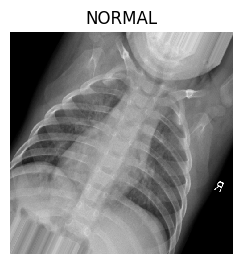

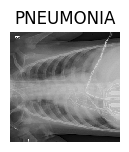

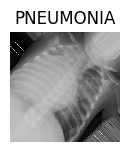

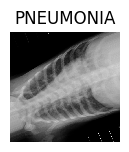

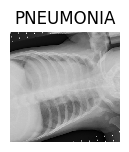

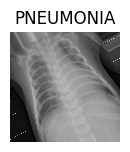

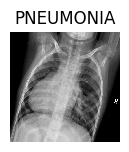

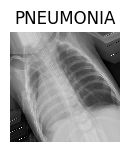

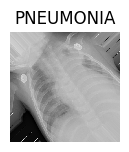

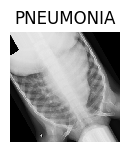

In [5]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image), cmap='gray', interpolation='nearest')
        break
    plt.tight_layout()
    plt.show()

*CNN Architecture*

In [6]:
cnn = Sequential()


cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_width, img_height, 1), kernel_regularizer=l2(l=0.01)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation='relu', input_shape=(img_width, img_height, 1), kernel_regularizer=l2(l=0.01)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = BinaryCrossentropy(), metrics = ['accuracy'])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

2023-05-21 10:51:57.946059: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 10:51:58.054420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-21 10:51:58.054529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

*Interpreting Model Summary*

In [7]:
Conv2D(filters=128, kernel_size=(3, 3),activation='relu', input_shape=(500, 500, 1))

MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)

*Visualize CNN model*

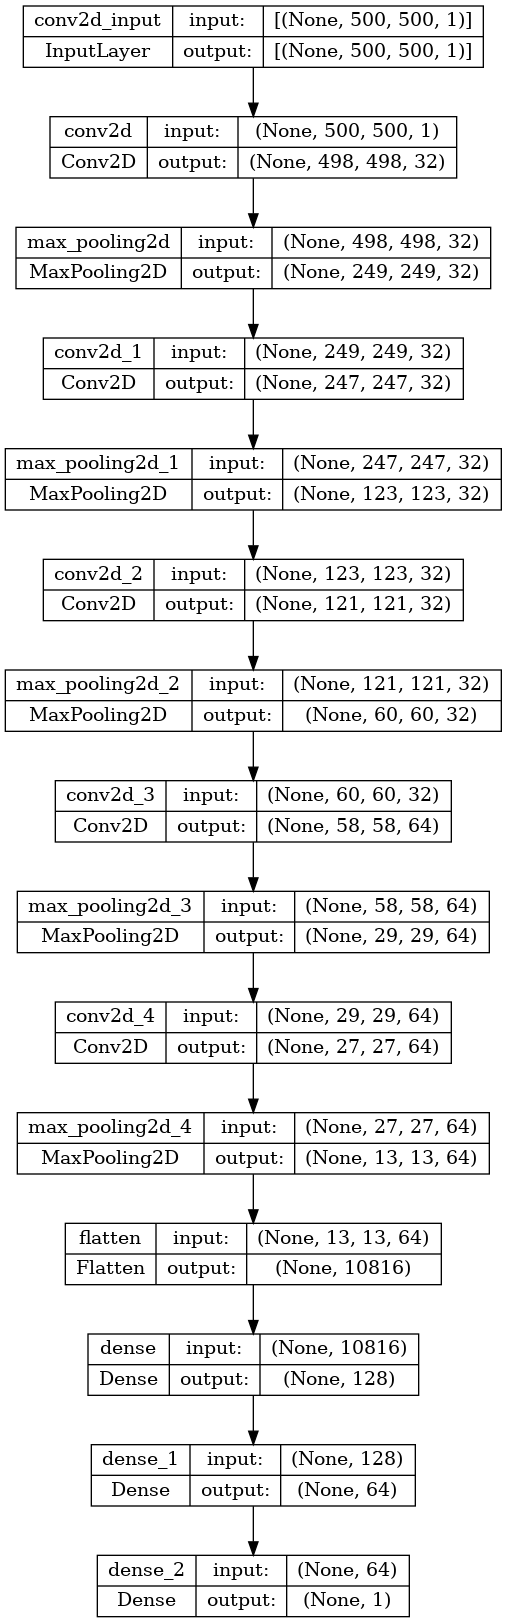

In [8]:
plot_model(cnn, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

*Fitting the model*

In [9]:
early = EarlyStopping(monitor='val_loss', mode='auto', patience=5)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.1, min_lr=0.000001)

checkpoint_filepath = '/home/gautam/Desktop/Pneumonia_chest_xray_classification/checkpoint/checkpoint.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)

callbacks_list = [early, learning_rate_reduction, checkpoint]

*Assigning Class Weights*

In [10]:
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip(np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


*Fitting the model*

In [11]:
cnn.fit(train, epochs=100, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/100


2023-05-21 10:51:59.743252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-21 10:52:01.589058: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-21 10:52:03.278570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-21 10:52:03.293967: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x38b95d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-21 10:52:03.293981: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-21 10:52:03.317369: I

131/131 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.7094

2023-05-21 10:52:35.133999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


131/131 [==============================] - 44s 294ms/step - loss: 0.7863 - accuracy: 0.7094 - val_loss: 0.4844 - val_accuracy: 0.8471 - lr: 0.0010
Epoch 2/100
131/131 [==============================] - 42s 319ms/step - loss: 0.3457 - accuracy: 0.8793 - val_loss: 0.2923 - val_accuracy: 0.9212 - lr: 0.0010
Epoch 3/100
131/131 [==============================] - 42s 318ms/step - loss: 0.2548 - accuracy: 0.9117 - val_loss: 0.2539 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/100
131/131 [==============================] - 42s 319ms/step - loss: 0.2560 - accuracy: 0.9082 - val_loss: 0.3086 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 5/100
131/131 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9272
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
131/131 [==============================] - 42s 317ms/step - loss: 0.2070 - accuracy: 0.9272 - val_loss: 0.2381 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 6/100
131/131 [==============================] - 

*Evaluating the model*

<Axes: >

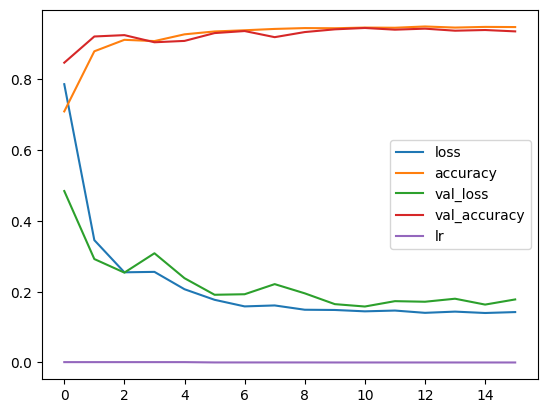

In [12]:
pd.DataFrame(cnn.history.history).plot()

*Loading Weights*

In [13]:
cnn.load_weights(checkpoint_filepath)

*Testing Accuracy*

In [14]:
test_loss, test_acc = cnn.evaluate(test)
print('Test Accuracy: ', test_acc*100, '%')

2023-05-21 11:03:10.028100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 5s 229ms/step - loss: 0.3466 - accuracy: 0.8910
Test Accuracy:  89.10256624221802 %


*Prediction*

In [15]:
preds= cnn.predict(test, verbose=1)

predictions = preds.copy()
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

2023-05-21 11:03:15.152937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 5s 224ms/step


*Creating a confusion matrix*

<Axes: >

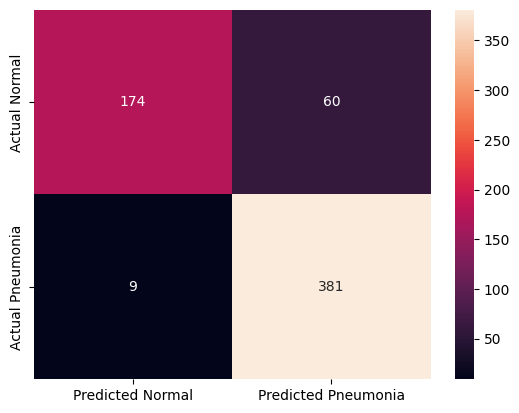

In [16]:
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]), index=['Actual Normal', 'Actual Pneumonia'], columns=['Predicted Normal', 'Predicted Pneumonia'])

sns.heatmap(cm, annot=True, fmt='d')

*Printing the report*

In [17]:
print(classification_report(y_true=test.classes, y_pred=predictions, target_names=['Normal', 'Pneumonia']))


              precision    recall  f1-score   support

      Normal       0.95      0.74      0.83       234
   Pneumonia       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.86      0.88       624
weighted avg       0.90      0.89      0.89       624



*Concatenating the 'test' sequence and get the shape of 'x' and 'y'*

In [18]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


In [19]:
tf.keras.models.save_model(cnn, 'pneumonia(Using L2).h5',save_format='h5')